In [1]:
import pandas as pd
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
from sklearn.model_selection import cross_val_score
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import math

%matplotlib inline

In [2]:
Labels = np.array(pd.read_csv('Labels.csv'))
Features = np.array(pd.read_csv('Features.csv'))

In [3]:
nr.seed(3247)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 80)
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

All cells above are similiar to the previous notebook.

In the previous notebook model was applied without any improvement or regularization. In this one, the model should be improved by manipulating some characteristics of the model or data itself. It is possible that some features are more important than other. Or that some of them are totally unused.

First the regression model will be created for comparison to the future improvement.

In [4]:
logistic_mod = linear_model.LogisticRegression(C = 1.0, solver = 'lbfgs', max_iter=7600, class_weight = {0:0.85, 1:0.15}) 
logistic_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight={0: 0.85, 1: 0.15}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=7600,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

                 Confusion matrix
                 Score positive    Score negative
Actual positive        36                 0
Actual negative        16                28

Accuracy        0.80
AUC             0.95
Macro precision 0.85
Macro recall    0.82
 
           Positive      Negative
Num case       36            44
Precision    0.69          1.00
Recall       1.00          0.64
F1           0.82          0.78


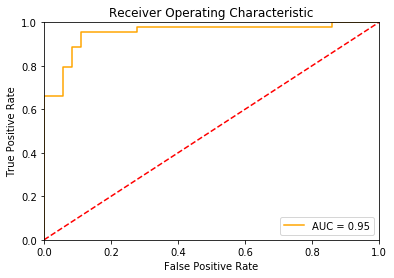

In [5]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

def print_metrics(labels, probs, threshold):
    scores = score_model(probs, threshold)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, probs[:,1]))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()    

probabilities = logistic_mod.predict_proba(X_test)
print_metrics(y_test, probabilities, 0.5)  
plot_auc(y_test, probabilities)

Results are slightly different to those from previous notebook. Notice that number of the seed changed so the test and train data are different from last one. So it is unsafe to evaluate the model only by one set of train and test data. In this particular set there are no false negatives which is promising.

# Cross - validation

In order to properly examine the model the cross - validation must be applied. Basically this is splitting dataset into x pieces. One of them is for testing, others are for training. And after validation process repeats itself but test part changes.

Below are results of the splitting dataset into 10 sets and examined by the same metrics as above. They are different from each other so the model behaves in a different way each time the dataset is randomly split.

In [6]:
Labels = Labels.reshape(Labels.shape[0],)
scoring = ['precision_macro', 'recall_macro', 'roc_auc']
logistic_mod = linear_model.LogisticRegression(C = 1.0, solver = 'lbfgs', max_iter=7600, class_weight = {0:0.85, 1:0.15}) 
scores = ms.cross_validate(logistic_mod, Features, Labels, scoring=scoring,
                        cv=10, return_train_score=False)

In [7]:
def print_format(f,x,y,z):
    print('Fold %2d    %4.3f        %4.3f      %4.3f' % (f, x, y, z))

def print_cv(scores):
    fold = [x + 1 for x in range(len(scores['test_precision_macro']))]
    print('         Precision     Recall       AUC')
    [print_format(f,x,y,z) for f,x,y,z in zip(fold, scores['test_precision_macro'], 
                                          scores['test_recall_macro'],
                                          scores['test_roc_auc'])]
    print('-' * 40)
    print('Mean       %4.3f        %4.3f      %4.3f' % 
          (np.mean(scores['test_precision_macro']), np.mean(scores['test_recall_macro']), np.mean(scores['test_roc_auc'])))  
    print('Std        %4.3f        %4.3f      %4.3f' % 
          (np.std(scores['test_precision_macro']), np.std(scores['test_recall_macro']), np.std(scores['test_roc_auc'])))

print_cv(scores)    

         Precision     Recall       AUC
Fold  1    0.782        0.782      0.916
Fold  2    0.754        0.714      0.893
Fold  3    0.850        0.812      0.924
Fold  4    0.850        0.812      0.973
Fold  5    0.819        0.808      0.933
Fold  6    0.780        0.656      0.871
Fold  7    0.825        0.781      0.942
Fold  8    0.842        0.812      0.947
Fold  9    0.811        0.805      0.870
Fold 10    0.767        0.767      0.870
----------------------------------------
Mean       0.808        0.775      0.914
Std        0.033        0.049      0.035


So this was a test for a model. But having that in mind how pick the best tuning value such as C and evalute it using cross - validation?

### Nested cross - validation

In [8]:
nr.seed(123)
inside = ms.KFold(n_splits=10, shuffle = True)
nr.seed(321)
outside = ms.KFold(n_splits=10, shuffle = True)

In [9]:
nr.seed(3456)

param_grid = {"C": [0.01, 0.1, 1, 10, 100]}
logistic_mod = linear_model.LogisticRegression(solver = 'lbfgs', max_iter=7600, class_weight = {0:0.85, 1:0.15}) 


clf = ms.GridSearchCV(estimator = logistic_mod, param_grid = param_grid, 
                      cv = inside,
                      scoring = 'roc_auc',
                      return_train_score = True)

In [10]:
clf.fit(Features, Labels)
keys = list(clf.cv_results_.keys())
for key in keys[6:16]:
    print(clf.cv_results_[key])

clf.best_estimator_.C

[0.89285714 0.96428571 0.97767857 0.98214286 0.98214286]
[0.84259259 0.9537037  0.93981481 0.94444444 0.93981481]
[0.655 0.78  0.825 0.82  0.82 ]
[0.58928571 0.65625    0.71428571 0.70535714 0.70089286]
[0.90666667 0.96444444 0.96       0.96444444 0.96444444]
[0.85777778 0.97777778 0.93777778 0.92888889 0.92888889]
[0.87037037 0.90740741 0.9212963  0.91666667 0.91203704]
[0.69230769 0.88461538 0.90865385 0.85576923 0.82692308]
[0.84210526 0.95789474 0.95789474 0.94736842 0.94736842]
[0.82828283 0.87373737 0.88888889 0.88383838 0.88888889]


1

The code above basically searchs for the best C value within given values from dictionary.

Performance metrics by parameter
Parameter   Mean performance   STD performance
    0.01        0.79772            0.10471
    0.10        0.89201            0.09733
    1.00        0.90313            0.07528
   10.00        0.89489            0.07904
  100.00        0.89114            0.08151


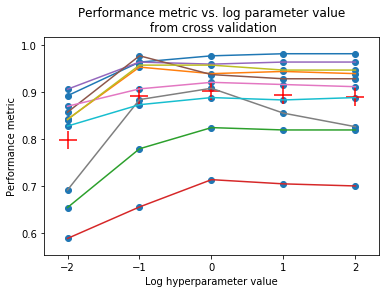

In [11]:
def plot_cv(clf, params_grid, param = 'C'):
    params = [x for x in params_grid[param]]
  
    keys = list(clf.cv_results_.keys())              
    grid = np.array([clf.cv_results_[key] for key in keys[6:16]])
    means = np.mean(grid, axis = 0)
    stds = np.std(grid, axis = 0)
    print('Performance metrics by parameter')
    print('Parameter   Mean performance   STD performance')
    for x,y,z in zip(params, means, stds):
        print('%8.2f        %6.5f            %6.5f' % (x,y,z))
    
    params = [math.log10(x) for x in params]
    
    plt.scatter(params * grid.shape[0], grid.flatten())
    p = plt.scatter(params, means, color = 'red', marker = '+', s = 300)
    plt.plot(params, np.transpose(grid))
    plt.title('Performance metric vs. log parameter value\n from cross validation')
    plt.xlabel('Log hyperparameter value')
    plt.ylabel('Performance metric')
    
plot_cv(clf, param_grid)    

As it is shown on parameter 1 behaves the best but there is not a huge difference between those values.

In [12]:
nr.seed(498)
cv_estimate = cross_val_score(clf, Features, Labels, 
                                 cv = outside)
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/skl

Mean performance metric = 0.899
SDT of the metric       = 0.055
Outcomes by cv fold
Fold  1    0.920
Fold  2    0.875
Fold  3    0.887
Fold  4    0.862
Fold  5    0.856
Fold  6    0.785
Fold  7    0.968
Fold  8    0.952
Fold  9    0.971
Fold 10    0.917


Thanks to this one the model parameter C improved the model performance.

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


For threshold: 0.75
                 Confusion matrix
                 Score positive    Score negative
Actual positive        36                 0
Actual negative        30                14

Accuracy        0.62
AUC             0.95
Macro precision 0.77
Macro recall    0.66
 
           Positive      Negative
Num case       36            44
Precision    0.55          1.00
Recall       1.00          0.32
F1           0.71          0.48


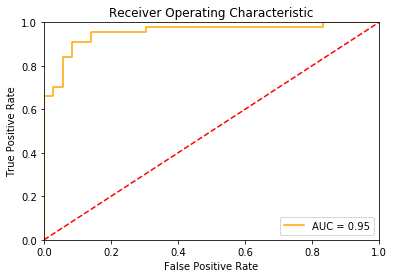

For threshold: 0.7
                 Confusion matrix
                 Score positive    Score negative
Actual positive        36                 0
Actual negative        29                15

Accuracy        0.64
AUC             0.95
Macro precision 0.78
Macro recall    0.67
 
           Positive      Negative
Num case       36            44
Precision    0.55          1.00
Recall       1.00          0.34
F1           0.71          0.51


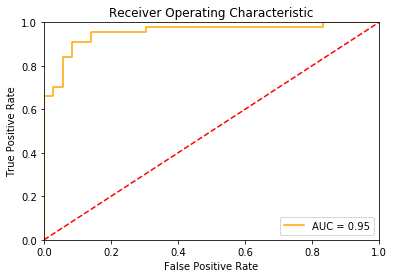

For threshold: 0.65
                 Confusion matrix
                 Score positive    Score negative
Actual positive        36                 0
Actual negative        20                24

Accuracy        0.75
AUC             0.95
Macro precision 0.82
Macro recall    0.77
 
           Positive      Negative
Num case       36            44
Precision    0.64          1.00
Recall       1.00          0.55
F1           0.78          0.71


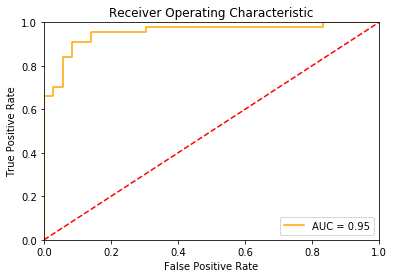

For threshold: 0.6
                 Confusion matrix
                 Score positive    Score negative
Actual positive        36                 0
Actual negative        19                25

Accuracy        0.76
AUC             0.95
Macro precision 0.83
Macro recall    0.78
 
           Positive      Negative
Num case       36            44
Precision    0.65          1.00
Recall       1.00          0.57
F1           0.79          0.72


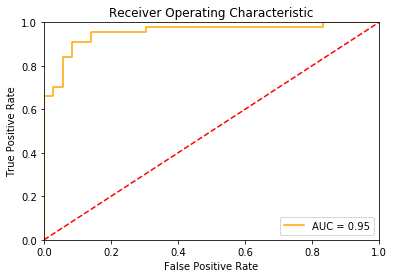

For threshold: 0.55
                 Confusion matrix
                 Score positive    Score negative
Actual positive        36                 0
Actual negative        18                26

Accuracy        0.78
AUC             0.95
Macro precision 0.83
Macro recall    0.80
 
           Positive      Negative
Num case       36            44
Precision    0.67          1.00
Recall       1.00          0.59
F1           0.80          0.74


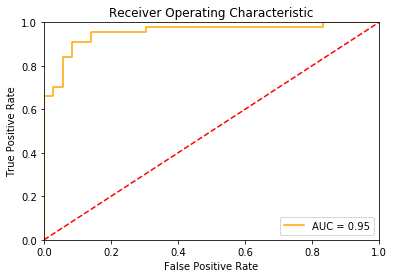

For threshold: 0.5
                 Confusion matrix
                 Score positive    Score negative
Actual positive        36                 0
Actual negative        15                29

Accuracy        0.81
AUC             0.95
Macro precision 0.85
Macro recall    0.83
 
           Positive      Negative
Num case       36            44
Precision    0.71          1.00
Recall       1.00          0.66
F1           0.83          0.79


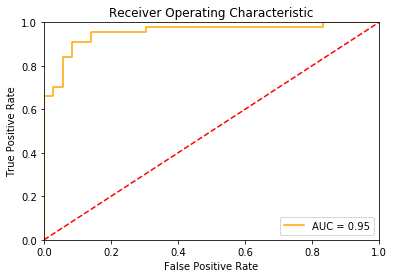

For threshold: 0.45
                 Confusion matrix
                 Score positive    Score negative
Actual positive        35                 1
Actual negative        15                29

Accuracy        0.80
AUC             0.95
Macro precision 0.83
Macro recall    0.82
 
           Positive      Negative
Num case       36            44
Precision    0.70          0.97
Recall       0.97          0.66
F1           0.81          0.78


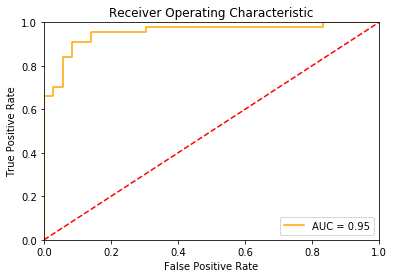

For threshold: 0.4
                 Confusion matrix
                 Score positive    Score negative
Actual positive        34                 2
Actual negative        13                31

Accuracy        0.81
AUC             0.95
Macro precision 0.83
Macro recall    0.82
 
           Positive      Negative
Num case       36            44
Precision    0.72          0.94
Recall       0.94          0.70
F1           0.82          0.81


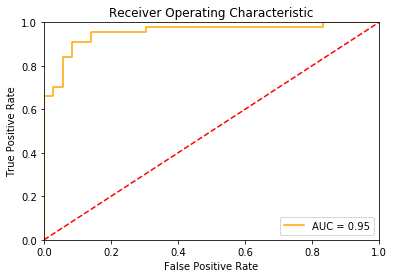

In [33]:
logistic_mod = linear_model.LogisticRegression(C = 1, class_weight = {0:0.85, 1:0.15}) 
logistic_mod.fit(X_train, y_train)
probabilities = logistic_mod.predict_proba(X_test)

thresholds = [0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4]
for t in thresholds:
    print('For threshold: ' + str(t))
    print_metrics(y_test, probabilities, t)  
    plot_auc(y_test, probabilities)

At this moment threshold value can be evaluated once again. As it is shown there is a great improvement. The value of threshold equal to 0.5 is perfectly balanced. There are no false positives and as less false negatives as it is possible.

## Feature selection

Many features are not very informative to the model. Either they have zero variance or low variance. In that cases model can be mislead by values supplied by those features. Beacouse of that it is wise to think about deleting those unneccesary features.

In [34]:
from sklearn import feature_selection as fs

In [35]:
print(Features.shape)

## Define the variance threhold and fit the threshold to the feature array. 
sel = fs.VarianceThreshold(threshold=(.8 * (1 - .8)))
Features_reduced = sel.fit_transform(Features)

## Print the support and shape for the transformed features
print(sel.get_support())
print(Features_reduced.shape)

(297, 29)
[ True  True  True False  True False False False  True  True  True  True
 False False  True  True  True  True False False False False  True  True
  True  True  True  True  True]
(297, 19)


Cell above states that 10 features are basically pointless. Examine if all the others features are importnat.

In [36]:
## Reshape the Label array
Labels = Labels.reshape(Labels.shape[0],)

## Set folds for nested cross validation
nr.seed(988)
feature_folds = ms.KFold(n_splits=10, shuffle = True)

## Define the model
logistic_mod = linear_model.LogisticRegression(C = 0.1, solver = 'lbfgs', max_iter=7600, class_weight = {0:0.85, 1:0.15}) 

## Perform feature selection by CV with high variance features only
nr.seed(6677)
selector = fs.RFECV(estimator = logistic_mod, cv = feature_folds,
                      scoring = 'roc_auc')
selector = selector.fit(Features_reduced, Labels)
selector.support_ 

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
        True])

In [37]:
selector.ranking_

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 4, 5, 6, 3, 1])

In [38]:
Features_reduced = selector.transform(Features_reduced)
Features_reduced.shape

(297, 14)

Another five features were found unimportant to the model. All important features were classified as 1. Higher than one are less important.

Text(0.5, 0, 'Number of features')

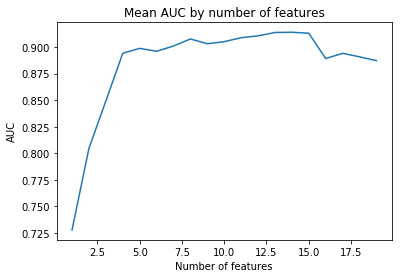

In [39]:
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.title('Mean AUC by number of features')
plt.ylabel('AUC')
plt.xlabel('Number of features')

In the picture above it is shown that the maximum of AUC is when number of features = 15 and is almost the same from 5 to 15.

Let's perform nested cross - validation one more time to see if C parameter changed.

In [40]:
nr.seed(123)
inside = ms.KFold(n_splits=10, shuffle = True)
nr.seed(321)
outside = ms.KFold(n_splits=10, shuffle = True)

In [41]:
nr.seed(3456)
## Define the dictionary for the grid search and the model object to search on
param_grid = {"C": [0.1, 1, 10, 100, 1000]}
## Define the logistic regression model
logistic_mod = linear_model.LogisticRegression(solver = 'lbfgs', max_iter=7600, class_weight = {0:0.85, 1:0.15}) 

## Perform the grid search over the parameters
clf = ms.GridSearchCV(estimator = logistic_mod, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'roc_auc',
                      return_train_score = True)

## Fit the cross validated grid search over the data 
clf.fit(Features_reduced, Labels)

## And print the best parameter value
clf.best_estimator_.C

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


1

The parameter C stays the same.

In [42]:
nr.seed(498)
cv_estimate = ms.cross_val_score(clf, Features, Labels, 
                                 cv = outside) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/skl

Mean performance metric = 0.899
SDT of the metric       = 0.055
Outcomes by cv fold
Fold  1    0.920
Fold  2    0.875
Fold  3    0.887
Fold  4    0.862
Fold  5    0.856
Fold  6    0.785
Fold  7    0.968
Fold  8    0.952
Fold  9    0.971
Fold 10    0.911


Mean performance metric did not change in comparison to the earlier nested cross - validation. So simplyfing the model and using only 15 instead of 29 features the model performed almost the same.

Let's test the model.

For threshold: 0.95
                 Confusion matrix
                 Score positive    Score negative
Actual positive        38                 0
Actual negative        42                 0

Accuracy        0.47
AUC             0.91
Macro precision 0.24
Macro recall    0.50
 
           Positive      Negative
Num case       38            42
Precision    0.47          0.00
Recall       1.00          0.00
F1           0.64          0.00


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


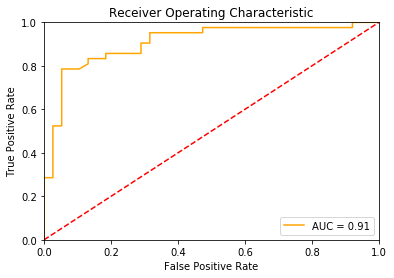

For threshold: 0.9
                 Confusion matrix
                 Score positive    Score negative
Actual positive        38                 0
Actual negative        42                 0

Accuracy        0.47
AUC             0.91
Macro precision 0.24
Macro recall    0.50
 
           Positive      Negative
Num case       38            42
Precision    0.47          0.00
Recall       1.00          0.00
F1           0.64          0.00


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


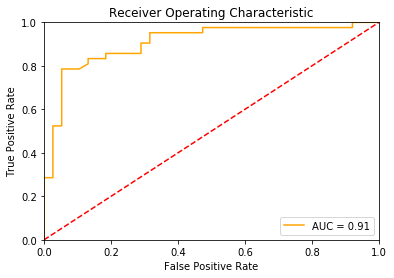

For threshold: 0.85
                 Confusion matrix
                 Score positive    Score negative
Actual positive        38                 0
Actual negative        40                 2

Accuracy        0.50
AUC             0.91
Macro precision 0.74
Macro recall    0.52
 
           Positive      Negative
Num case       38            42
Precision    0.49          1.00
Recall       1.00          0.05
F1           0.66          0.09


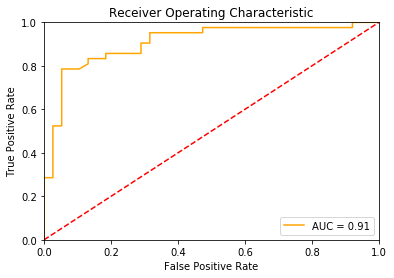

For threshold: 0.8
                 Confusion matrix
                 Score positive    Score negative
Actual positive        38                 0
Actual negative        37                 5

Accuracy        0.54
AUC             0.91
Macro precision 0.75
Macro recall    0.56
 
           Positive      Negative
Num case       38            42
Precision    0.51          1.00
Recall       1.00          0.12
F1           0.67          0.21


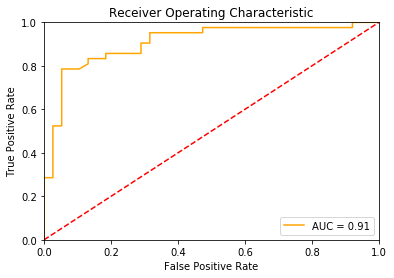

For threshold: 0.75
                 Confusion matrix
                 Score positive    Score negative
Actual positive        38                 0
Actual negative        36                 6

Accuracy        0.55
AUC             0.91
Macro precision 0.76
Macro recall    0.57
 
           Positive      Negative
Num case       38            42
Precision    0.51          1.00
Recall       1.00          0.14
F1           0.68          0.25


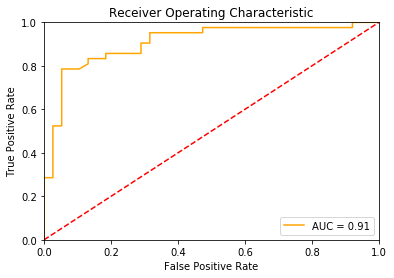

For threshold: 0.7
                 Confusion matrix
                 Score positive    Score negative
Actual positive        38                 0
Actual negative        33                 9

Accuracy        0.59
AUC             0.91
Macro precision 0.77
Macro recall    0.61
 
           Positive      Negative
Num case       38            42
Precision    0.54          1.00
Recall       1.00          0.21
F1           0.70          0.35


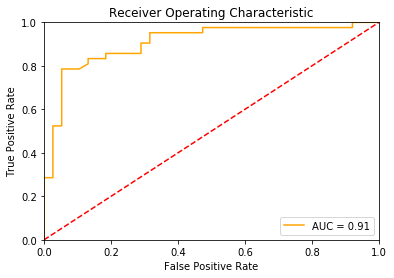

For threshold: 0.65
                 Confusion matrix
                 Score positive    Score negative
Actual positive        37                 1
Actual negative        28                14

Accuracy        0.64
AUC             0.91
Macro precision 0.75
Macro recall    0.65
 
           Positive      Negative
Num case       38            42
Precision    0.57          0.93
Recall       0.97          0.33
F1           0.72          0.49


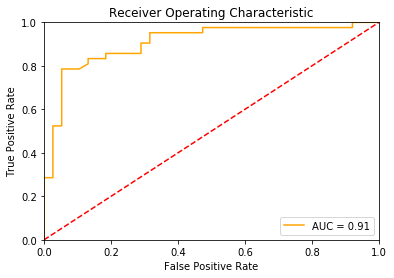

For threshold: 0.6
                 Confusion matrix
                 Score positive    Score negative
Actual positive        37                 1
Actual negative        25                17

Accuracy        0.68
AUC             0.91
Macro precision 0.77
Macro recall    0.69
 
           Positive      Negative
Num case       38            42
Precision    0.60          0.94
Recall       0.97          0.40
F1           0.74          0.57


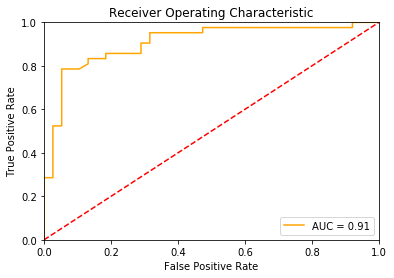

For threshold: 0.55
                 Confusion matrix
                 Score positive    Score negative
Actual positive        37                 1
Actual negative        23                19

Accuracy        0.70
AUC             0.91
Macro precision 0.78
Macro recall    0.71
 
           Positive      Negative
Num case       38            42
Precision    0.62          0.95
Recall       0.97          0.45
F1           0.76          0.61


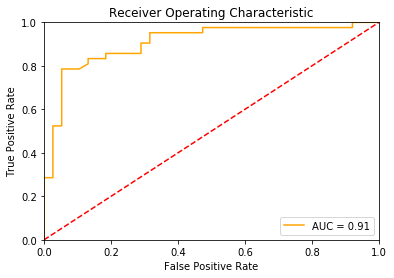

In [52]:
nr.seed(7985)
indx = range(Features_reduced.shape[0])
indx = ms.train_test_split(indx, test_size = 80)
X_train = Features_reduced[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features_reduced[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

logistic_mod = linear_model.LogisticRegression(C = 1, solver = 'lbfgs', max_iter=7600, class_weight = {0:0.85, 1:0.15}) 
logistic_mod.fit(X_train, y_train)
probabilities = logistic_mod.predict_proba(X_test)

thresholds = [0.95, 0.90, 0.85, 0.80, 0.75, 0.7, 0.65, 0.6, 0.55]
for t in thresholds:
    print('For threshold: ' + str(t))
    print_metrics(y_test, probabilities, t)  
    plot_auc(y_test, probabilities)

In this particular seed of data the results are worse than after first nested cross - validation. Note that results are different each time the seed is randomly generated. Overall performance will be shown in the further section.

In [53]:
pd.DataFrame(Features_reduced).to_csv("Features reduced.csv", index=None)
Features = np.array(pd.read_csv('Features reduced.csv'))
Labels = np.array(pd.read_csv('Labels.csv'))

Are last 14 features the best choice for the model to perform? Maybe some of them are unnceccesary and they can be reduced.

### Dimensionality reduction

In [54]:
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 80)
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

In [55]:
import sklearn.decomposition as skde
pca_mod = skde.PCA()
pca_comps = pca_mod.fit(X_train)
pca_comps

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

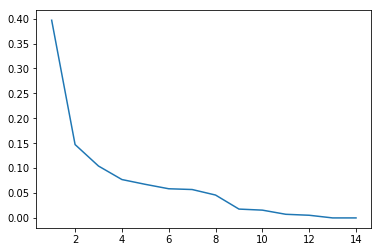

In [56]:
def plot_explained(mod):
    comps = mod.explained_variance_ratio_
    x = range(len(comps))
    x = [y + 1 for y in x]          
    plt.plot(x,comps)

plot_explained(pca_comps)

Code above uses principle component analysis (PCA) to reduce features. There is a interesting point on the graph where number of features is 9. After this value variances of the features are quite low.

In [57]:
pca_mod_5 = skde.PCA(n_components = 5)
pca_mod_5.fit(X_train)
Comps = pca_mod_5.transform(X_train)

log_mod_5 = linear_model.LogisticRegression(C = 1, solver = 'lbfgs', max_iter=7600, class_weight = {0:0.85, 1:0.15}) 
log_mod_5.fit(Comps, y_train)
print(log_mod_5.intercept_)
print(log_mod_5.coef_)

[-1.45933086]
[[-1.30065219  1.3110904  -0.41590357 -0.38341175 -0.80999536]]


                 Confusion matrix
                 Score positive    Score negative
Actual positive        31                 2
Actual negative        17                30

Accuracy        0.76
AUC             0.89
Macro precision 0.79
Macro recall    0.79
 
           Positive      Negative
Num case       33            47
Precision    0.65          0.94
Recall       0.94          0.64
F1           0.77          0.76


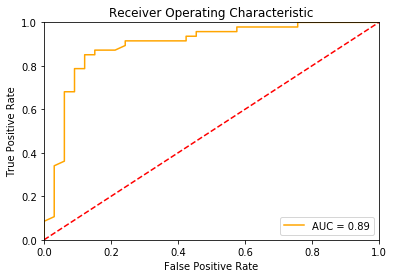

In [58]:
probabilities = log_mod_5.predict_proba(pca_mod_5.transform(X_test))
print_metrics(y_test, probabilities, 0.5)    
plot_auc(y_test, probabilities)  

In [59]:
pca_mod = skde.PCA(n_components = 5)
pca_mod.fit(Features)
Comps = pca_mod.transform(Features)

scores = ms.cross_validate(log_mod_5, Comps, Labels.ravel(), scoring=scoring,
                        cv=10, return_train_score=False)
print_cv(scores) 

         Precision     Recall       AUC
Fold  1    0.760        0.729      0.908
Fold  2    0.775        0.746      0.906
Fold  3    0.833        0.781      0.920
Fold  4    0.804        0.719      0.991
Fold  5    0.775        0.746      0.908
Fold  6    0.780        0.656      0.922
Fold  7    0.744        0.712      0.909
Fold  8    0.861        0.844      0.942
Fold  9    0.837        0.837      0.889
Fold 10    0.842        0.812      0.928
----------------------------------------
Mean       0.801        0.758      0.922
Std        0.038        0.057      0.027


In [60]:
pca_mod = skde.PCA(n_components = 14)
pca_mod.fit(Features)
Comps = pca_mod.transform(Features)

scores = ms.cross_validate(log_mod_5, Comps, Labels.ravel(), scoring=scoring,
                        cv=10, return_train_score=False)
print_cv(scores)

         Precision     Recall       AUC
Fold  1    0.780        0.758      0.912
Fold  2    0.775        0.746      0.906
Fold  3    0.833        0.781      0.942
Fold  4    0.804        0.719      0.982
Fold  5    0.797        0.777      0.926
Fold  6    0.769        0.625      0.913
Fold  7    0.744        0.712      0.899
Fold  8    0.842        0.812      0.952
Fold  9    0.767        0.767      0.875
Fold 10    0.861        0.844      0.909
----------------------------------------
Mean       0.797        0.754      0.922
Std        0.036        0.057      0.029


In [66]:
pca_mod = skde.PCA(n_components = 10)
pca_mod.fit(Features)
Comps = pca_mod.transform(Features)

scores = ms.cross_validate(log_mod_5, Comps, Labels.ravel(), scoring=scoring,
                        cv=10, return_train_score=False)
print_cv(scores) 

         Precision     Recall       AUC
Fold  1    0.780        0.758      0.912
Fold  2    0.775        0.746      0.906
Fold  3    0.833        0.781      0.942
Fold  4    0.804        0.719      0.982
Fold  5    0.797        0.777      0.926
Fold  6    0.769        0.625      0.913
Fold  7    0.744        0.712      0.899
Fold  8    0.842        0.812      0.952
Fold  9    0.767        0.767      0.875
Fold 10    0.861        0.844      0.909
----------------------------------------
Mean       0.797        0.754      0.922
Std        0.036        0.057      0.029


As it is shown above the best option is 10 most important features. Ten most important features behaves the same way as 14. So basically fifteen features were reduced from the original preprocessed dataset. 

In [67]:
print(Comps.shape)
pd.DataFrame(Comps).to_csv("Features reducedv2.csv", index=None)

(297, 10)


In [71]:
Features = Comps

In [73]:
nr.seed(498)
cv_estimate = ms.cross_val_score(clf, Features, Labels.ravel(), 
                                 cv = outside) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/skl

Mean performance metric = 0.914
SDT of the metric       = 0.054
Outcomes by cv fold
Fold  1    0.924
Fold  2    0.864
Fold  3    0.885
Fold  4    0.888
Fold  5    0.898
Fold  6    0.806
Fold  7    0.968
Fold  8    0.948
Fold  9    1.000
Fold 10    0.958


Model improved on the same seed data.
Another random seed:

In [74]:
nr.seed(357)
cv_estimate = ms.cross_val_score(clf, Features, Labels.ravel(), 
                                 cv = outside) # Use the outside folds
print('Mean performance metric = %4.3f' % np.mean(cv_estimate))

print('SDT of the metric       = %4.3f' % np.std(cv_estimate))
print('Outcomes by cv fold')
for i, x in enumerate(cv_estimate):
    print('Fold %2d    %4.3f' % (i+1, x))

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/skl

Mean performance metric = 0.917
SDT of the metric       = 0.046
Outcomes by cv fold
Fold  1    0.896
Fold  2    0.971
Fold  3    0.838
Fold  4    0.924
Fold  5    0.946
Fold  6    0.839
Fold  7    0.969
Fold  8    0.914
Fold  9    0.957
Fold 10    0.919


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
